Connect to Google drive

In [0]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Upload file

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def upload(name):
  uploaded = drive.CreateFile({'title': name})
  uploaded.SetContentFile(name)
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))

Generate data from openpose data

In [0]:
import pandas as pd
import numpy as np

In [0]:
PATH = './drive/My Drive/636/dataset/'
file_path = PATH + 'dataset_dropped.csv'

In [0]:
dataset = pd.read_csv(file_path)

Reshape Data into Segments and Prepare for Keras

In [0]:
# get number of features
N_FEATURES = dataset.shape[1] - 2

In [0]:
# slice every 10 frame as a segment until the last frame reaches the end
def get_slices(df, index_arr, TIME_STAMP):
  slices = []
  size = len(index_arr)
  i = index_arr[0]
  if size >= TIME_STAMP:
    while i + TIME_STAMP <= index_arr[-1] + 1:
      slices.append(df.values[df.index[i : i + TIME_STAMP]])
      i += 1
  else:
    slice_ = df.values[df.index[index_arr]]
    fillzero = np.zeros((TIME_STAMP - size, N_FEATURES))
    slice_ = np.concatenate((slice_, fillzero), axis=0)
    slices.append(slice_)
  slices_arr = np.asarray(slices, dtype= np.float32)
  return slices_arr

In [0]:
# slice every 10 frame as a segment until the last frame reaches the end
def get_label_slices(df, index_arr, TIME_STAMP):
  slices_arr = []
  size = len(index_arr)
  i = index_arr[0]
  if size >= TIME_STAMP:
    slices = dataset.label[index_arr[0] + TIME_STAMP - 1 : index_arr[-1] + 1]
  else:
    slices = dataset.label[index_arr[-1] : index_arr[-1] + 1]

  slices_arr = np.concatenate((slices_arr, slices), axis=0)
  return slices_arr

In [0]:
def create_segments_and_labels(df, TIME_STAMP):
  # get people id
  people_id = df.person_id.unique()
  segments = []
  labels = []
  # get segment of each person_id
  for i in people_id:
    # slice every 10 frame as a segment and use the first label as label of segment
    # get all index of an id
    index_arr = df.index[df['person_id'] == i]
    # drop the id and label
    df_s = df[df.columns[1:-1]]
    df_l = df[['person_id', 'label']]
    if i == 1:
      segments = get_slices(df_s, index_arr, TIME_STAMP)
      labels = get_label_slices(df_l, index_arr, TIME_STAMP)
    elif i > 1:
      # get slices of each person
      segment = get_slices(df_s, index_arr, TIME_STAMP)
      label = get_label_slices(df_l, index_arr, TIME_STAMP)
      # print(i, segment.shape)
      # get label of each slices
      segments = np.concatenate((segments, segment), axis=0)
      labels = np.concatenate((labels, label), axis=0)
  return segments, labels

In [0]:
X, y = create_segments_and_labels(dataset, 10)

In [0]:
X.shape

(5308, 10, 210)

In [0]:
y.shape

(5308,)

Build model

In [0]:
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, LSTM, LSTM, Dropout, Flatten
from keras.callbacks import History, EarlyStopping

Using TensorFlow backend.


In [0]:
def create_model():
  model = Sequential()
  model.add(Dense(64, activation='relu'))
  model.add(LSTM(64))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [0]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 10, 32)            6752      
_________________________________________________________________
lstm_20 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 33        
Total params: 15,105
Trainable params: 15,105
Non-trainable params: 0
_________________________________________________________________


K-fold

In [0]:
from sklearn.model_selection import StratifiedKFold
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define 4-fold cross validation test harness
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)
scores = []
i = 0
for train, test in kfold.split(X, y):
  print('K-fold: %d\n' % i)
  i += 1
  model = create_model()
  history = model.fit(X[train], y[train], epochs=30, batch_size=50, 
                      validation_split=0.2, verbose=2, callbacks=callbacks_list)
  score = model.evaluate(X[test], y[test], verbose=2)
  scores.append(score)

K-fold: 0

Train on 3184 samples, validate on 797 samples
Epoch 1/30
 - 5s - loss: 0.6883 - acc: 0.5389 - val_loss: 0.7532 - val_acc: 0.0000e+00
Epoch 2/30
 - 1s - loss: 0.7016 - acc: 0.4560 - val_loss: 0.9263 - val_acc: 0.0000e+00
Epoch 3/30
 - 1s - loss: 0.6815 - acc: 0.5204 - val_loss: 0.7431 - val_acc: 0.0000e+00
Epoch 4/30
 - 1s - loss: 0.6019 - acc: 0.6891 - val_loss: 0.8411 - val_acc: 0.0941
Epoch 5/30
 - 1s - loss: 0.5556 - acc: 0.8031 - val_loss: 0.6290 - val_acc: 0.7528
Epoch 6/30
 - 1s - loss: 0.4073 - acc: 0.8753 - val_loss: 0.3099 - val_acc: 0.9900
Epoch 7/30
 - 1s - loss: 0.3234 - acc: 0.9149 - val_loss: 0.1713 - val_acc: 0.9912
Epoch 8/30
 - 1s - loss: 0.3010 - acc: 0.9080 - val_loss: 0.7400 - val_acc: 0.6148
Epoch 9/30
 - 1s - loss: 0.2675 - acc: 0.9256 - val_loss: 0.2367 - val_acc: 0.9322
Epoch 10/30
 - 1s - loss: 0.2255 - acc: 0.9287 - val_loss: 0.1199 - val_acc: 0.9937
Epoch 11/30
 - 1s - loss: 0.2092 - acc: 0.9344 - val_loss: 0.0617 - val_acc: 0.9912
Epoch 12/30
 - 

In [0]:
scores

[[0.18869060018473918, 0.9427279577995479],
 [0.17323216313907502, 0.9570459683496609],
 [0.1470800221103897, 0.9510173323285607],
 [0.16255782545735806, 0.9555388093443858]]

Save model

In [0]:
model.save('model.h5')
upload('model.h5')

Uploaded file with ID 1Rl8T-tsfcIZWcjI6eggzhfy3SL0yQRbR


Draw figure

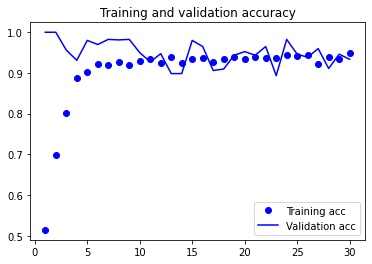

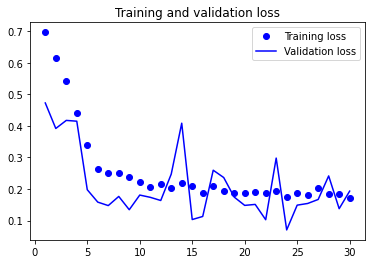

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()